# Self-drive car Kaggle Challenge

# 1) Importing key modules

In [105]:
# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [106]:
# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [107]:
# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [108]:
# for data processing
import nltk
import pandas as pd
import numpy as np
import gensim

In [109]:
# Other imports
from collections import Counter
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [110]:
# For machine learning processing
from nltk.corpus import stopwords
import string
import math
import sklearn
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve, GridSearchCV

In [111]:
# For models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# 2) LOADING THE DATASET

In [112]:

data = pd.read_csv('cleaned_sentiment_self_cars.csv', encoding= 'utf-8')
data.head()

,sentiment,text,cleaned,Sent_compound_Polarity,Sent_type
0,5,@manjulamartin @Kirk_Gleason Except trains are...,manjulamartin kirk gleason except train capita...,0.5106,Positive
1,5,I want a Google driverless car.,want google driverless car,0.0772,Positive
2,5,@Oatmeal @google driverless @TeslaMotors ? Ooo...,oatmeal google driverless teslamotors ooooh wo...,0.6892,Positive
3,5,SO MUCH AWESOME! Amazing video for GoogleÌ¢‰âÂ...,much awesome amazing video google next phase d...,0.9157,Positive
4,5,@google is making driverless cars which is awe...,google making driverless car awesome http co h...,0.6249,Positive


In [113]:
data.columns

Index(['sentiment', 'text', 'cleaned', 'Sent_compound_Polarity', 'Sent_type'], dtype='object')

In [114]:
# SHAPE OF THE DATASET
print("Shape of the dataset:")
print(data.shape)

Shape of the dataset:
(981, 5)


In [115]:
data_test = pd.read_csv('test.csv')

In [116]:
data_test.shape

(979, 2)

In [117]:
data_test.head()

,id,text
0,1,Two places I'd invest all my money if I could:...
1,2,Awesome! Google driverless cars will help the ...
2,3,Autonomous vehicles could reduce traffic fatal...
3,4,Really good presentation from Jan Becker on Bo...
4,5,Ford just revealed it's Automated Ford Fusion ...


## 2.1) In-balance data-points

**We can see that train has 981 data-points and test has 979. To balance this, we will remove last two values of train-set<br>
Let's check if there are any duplicate tweets in our train dataset**

In [118]:
print(data.text.duplicated())

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
951    False
952    False
953    False
954    False
955    False
956    False
957    False
958    False
959    False
960    False
961    False
962    False
963    False
964    False
965    False
966    False
967    False
968    False
969    False
970    False
971    False
972    False
973    False
974    False
975    False
976    False
977    False
978    False
979    False
980    False
Name: text, Length: 981, dtype: bool


**It seems that there are no duplicate values. We have not seen all. To check in detail, sum them all**

In [119]:
print(data.text.duplicated().sum())

0


In [120]:
# Lets check whole dataset
print(data.duplicated().sum())

0


In [121]:
# To check exact location by row
data.loc[data.duplicated() , :]

,sentiment,text,cleaned,Sent_compound_Polarity,Sent_type


Confirmed, there is no duplicate text in our dataset. Now, we choose at random two points to balance it

In [122]:
data.drop([3,63], axis=0, inplace= True)
# For rows, axis=0, inplace will make change without storing 

In [123]:
data.shape

(979, 5)

**Now we have 979 data points. Let's see more of data**

In [124]:
# DATATYPE OF EACH COLUMN
print("Datatype of each column:")
print(data.dtypes)

Datatype of each column:
sentiment                   int64
text                       object
cleaned                    object
Sent_compound_Polarity    float64
Sent_type                  object
dtype: object


In [125]:
# DATASET SUMMARY
data.describe(include='all')

,sentiment,text,cleaned,Sent_compound_Polarity,Sent_type
count,979.00000,979,979,979.000000,979
unique,NaN,979,976,NaN,3
top,NaN,"@JElvisWeinstein Oh, then your car must be dri...",driverless car,NaN,Neutral
freq,NaN,1,2,NaN,405
mean,3.13381,NaN,NaN,0.059077,NaN
std,0.78422,NaN,NaN,0.356868,NaN
min,1.00000,NaN,NaN,-0.938000,NaN
25%,3.00000,NaN,NaN,0.000000,NaN
50%,3.00000,NaN,NaN,0.000000,NaN
75%,3.00000,NaN,NaN,0.318200,NaN


## 2.2) Create new features

In [126]:
#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
data['length'] = data['text'].apply(len)
data.head()

,sentiment,text,cleaned,Sent_compound_Polarity,Sent_type,length
0,5,@manjulamartin @Kirk_Gleason Except trains are...,manjulamartin kirk gleason except train capita...,0.5106,Positive,140
1,5,I want a Google driverless car.,want google driverless car,0.0772,Positive,31
2,5,@Oatmeal @google driverless @TeslaMotors ? Ooo...,oatmeal google driverless teslamotors ooooh wo...,0.6892,Positive,72
4,5,@google is making driverless cars which is awe...,google making driverless car awesome http co h...,0.6249,Positive,73
5,5,You could call a driverless car and tell the c...,could call driverless car tell car take whoo hoo,0.0000,Neutral,84


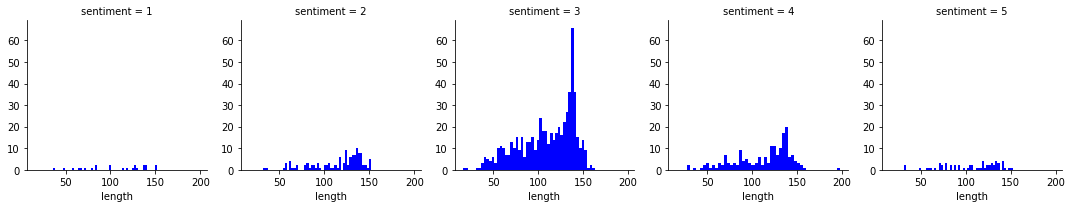

In [127]:
# COMPARING TEXT LENGTH TO Sentiments
graph = sns.FacetGrid(data=data,col='sentiment')
graph.map(plt.hist,'length',bins=50,color='blue')

# 3) Preparing for model

## 3.1) Finalize key features

In [128]:
data = data.copy()

In [129]:
X=data['cleaned']

In [130]:
# We need to work over y-variable
data['sent_numeric'] = data.Sent_type.map({'Negative':0, 'Positive':1, 'Neutral':2})

In [131]:
data.head()

,sentiment,text,cleaned,Sent_compound_Polarity,Sent_type,length,sent_numeric
0,5,@manjulamartin @Kirk_Gleason Except trains are...,manjulamartin kirk gleason except train capita...,0.5106,Positive,140,1
1,5,I want a Google driverless car.,want google driverless car,0.0772,Positive,31,1
2,5,@Oatmeal @google driverless @TeslaMotors ? Ooo...,oatmeal google driverless teslamotors ooooh wo...,0.6892,Positive,72,1
4,5,@google is making driverless cars which is awe...,google making driverless car awesome http co h...,0.6249,Positive,73,1
5,5,You could call a driverless car and tell the c...,could call driverless car tell car take whoo hoo,0.0000,Neutral,84,2


In [132]:
y=data.sent_numeric

In [133]:
type(y)

pandas.core.series.Series

In [134]:
y.value_counts()

2    405
1    360
0    214
Name: sent_numeric, dtype: int64

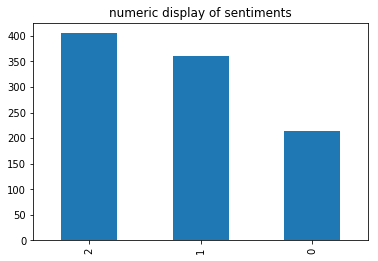

In [135]:
y.value_counts().plot (kind='bar' , title="numeric display of sentiments")

In [136]:
print(X.shape)
print(y.shape)

(979,)
(979,)


## 3.2) Split X and y into training and testing sets

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(734,)
(245,)
(734,)
(245,)


# 3.3) Vectorize

In [138]:
# instantiate the vectorizer
vect = CountVectorizer()
# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

In [139]:
type(X_train_dtm)

scipy.sparse.csr.csr_matrix

In [140]:
X_train_dtm

<734x3002 sparse matrix of type '<class 'numpy.int64'>'
	with 8477 stored elements in Compressed Sparse Row format>

In [141]:
X_train_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [142]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<245x3002 sparse matrix of type '<class 'numpy.int64'>'
	with 2112 stored elements in Compressed Sparse Row format>

In [143]:
X_test_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

**Summary:**

- `vect.fit(train)` **learns the vocabulary** of the training data
- `vect.transform(train)` uses the **fitted vocabulary** to build a document-term matrix from the training data
- `vect.transform(test)` uses the **fitted vocabulary** to build a document-term matrix from the testing data (and **ignores tokens** it hasn't seen before)

# 4) Building Model

## 4.1)-Logistic Regression

In [144]:
lr = LogisticRegression()
lr.fit(X_train_dtm,y_train)
predictions_LR = lr.predict(X_test_dtm)

In [145]:
print(accuracy_score(y_test,predictions_LR))

0.5918367346938775


In [146]:
score_lr = metrics.accuracy_score(y_test, predictions_LR)
score_lr

0.5918367346938775

In [147]:
print("Confusion Matrix for Logistic Regression:")
print(confusion_matrix(y_test,predictions_LR))

Confusion Matrix for Logistic Regression:
[[18 12 23]
 [12 45 36]
 [ 1 16 82]]


In [148]:
print("Classification Report:\n",classification_report(y_test,predictions_LR))

Classification Report:
              precision    recall  f1-score   support

          0       0.58      0.34      0.43        53
          1       0.62      0.48      0.54        93
          2       0.58      0.83      0.68        99

avg / total       0.59      0.59      0.57       245



**These scores are not very impressive. Let's apply other models to check if we could improve accuracy**

## 4.2)-Naive Bayes

In [149]:
mnb = MultinomialNB()
mnb.fit(X_train_dtm,y_train)
predmnb = mnb.predict(X_test_dtm)

In [150]:
score_mnb=metrics.accuracy_score(y_test,predmnb)
score_mnb

0.6122448979591837

In [151]:
print("Confusion Matrix for Multinomial Naive Bayes:")
print(confusion_matrix(y_test,predmnb))

Confusion Matrix for Multinomial Naive Bayes:
[[17 15 21]
 [10 57 26]
 [ 0 23 76]]


In [152]:
print("Classification Report:\n",classification_report(y_test,predmnb))

Classification Report:
              precision    recall  f1-score   support

          0       0.63      0.32      0.42        53
          1       0.60      0.61      0.61        93
          2       0.62      0.77      0.68        99

avg / total       0.61      0.61      0.60       245



## 4.3)-Support Vector Machines

In [153]:
svm = SVC()
svm.fit(X_train_dtm,y_train)
predsvm = svm.predict(X_test_dtm)

In [154]:
score_svm=metrics.accuracy_score(y_test,predsvm)
score_svm

0.40408163265306124

In [155]:
print("Confusion Matrix for Support Vector:")
print(confusion_matrix(y_test,predsvm))

Confusion Matrix for Support Vector:
[[ 0  0 53]
 [ 0  0 93]
 [ 0  0 99]]


In [156]:
print("Classification Report:\n",classification_report(y_test,predsvm))

Classification Report:
              precision    recall  f1-score   support

          0       0.00      0.00      0.00        53
          1       0.00      0.00      0.00        93
          2       0.40      1.00      0.58        99

avg / total       0.16      0.40      0.23       245



## 4.4)-K - Nearest Neighbor Classifier

In [157]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_dtm,y_train)
predknn = knn.predict(X_test_dtm)

In [158]:
score_knn=metrics.accuracy_score(y_test,predknn)
score_knn

0.4122448979591837

In [159]:
print("Confusion Matrix for KNN:")
print(confusion_matrix(y_test,predknn))

Confusion Matrix for KNN:
[[ 1  0 52]
 [ 2  1 90]
 [ 0  0 99]]


In [160]:
print("Classification Report:\n",classification_report(y_test,predknn))

Classification Report:
              precision    recall  f1-score   support

          0       0.33      0.02      0.04        53
          1       1.00      0.01      0.02        93
          2       0.41      1.00      0.58        99

avg / total       0.62      0.41      0.25       245



## 4.5)-Decision Tree

In [161]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train_dtm,y_train)
preddt = dt.predict(X_test_dtm)

In [195]:
len(preddt)

245

In [162]:
score_dt=metrics.accuracy_score(y_test,preddt)
score_dt

0.6285714285714286

In [163]:
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test,preddt))

Confusion Matrix for Decision Tree:
[[23  9 21]
 [ 9 48 36]
 [ 3 13 83]]


In [164]:
print("Classification Report:\n",classification_report(y_test,preddt))

Classification Report:
              precision    recall  f1-score   support

          0       0.66      0.43      0.52        53
          1       0.69      0.52      0.59        93
          2       0.59      0.84      0.69        99

avg / total       0.64      0.63      0.62       245



## 4.6)- Random Forest


In [165]:
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(X_train_dtm,y_train)
predrmfr = rmfr.predict(X_test_dtm)

In [166]:
score_rmfr=metrics.accuracy_score(y_test,predrmfr)
score_rmfr

0.5918367346938775

In [167]:
print("Confusion Matrix for Random Forest:")
print(confusion_matrix(y_test,predrmfr))

Confusion Matrix for Random Forest:
[[16 15 22]
 [ 5 41 47]
 [ 1 10 88]]


In [168]:
print("Classification Report:\n",classification_report(y_test,predrmfr))

Classification Report:
              precision    recall  f1-score   support

          0       0.73      0.30      0.43        53
          1       0.62      0.44      0.52        93
          2       0.56      0.89      0.69        99

avg / total       0.62      0.59      0.57       245



## 4.7)- Gradiant Boosting classifier

In [169]:
from sklearn.ensemble import GradientBoostingClassifier
"""# parameter evaluation
gbe = GradientBoostingClassifier(random_state=0)
parameters = {
     'learning_rate': [0.05, 0.1, 0.5],
    'max_features': [0.5, 1],
    'max_depth': [3, 4, 5]}
gridsearch=GridSearchCV(gbe,parameters,cv=100,scoring='roc_auc')
gridsearch.fit(x,y)
print(gridsearch.best_params_)
print(gridsearch.best_score_)"""
#Boosting
gbi = GradientBoostingClassifier(learning_rate=0.1,max_depth=5,max_features=0.5,random_state=2019)
gbi.fit(X_train_dtm,y_train)
predgbi = gbi.predict(X_test_dtm)

In [170]:
score_gbi=metrics.accuracy_score(y_test,predgbi)
score_gbi

0.6204081632653061

In [171]:
print("Confusion Matrix for Gradient Boosting Classifier:")
print(confusion_matrix(y_test,predgbi))

Confusion Matrix for Gradient Boosting Classifier:
[[21  8 24]
 [12 43 38]
 [ 1 10 88]]


In [172]:
print("Classification Report:",classification_report(y_test,predgbi))

Classification Report:              precision    recall  f1-score   support

          0       0.62      0.40      0.48        53
          1       0.70      0.46      0.56        93
          2       0.59      0.89      0.71        99

avg / total       0.64      0.62      0.60       245



In [173]:
#keeping minimum range
gbi = GradientBoostingClassifier(learning_rate=0.05,max_depth=3,max_features=0.5,random_state=2019)
gbi.fit(X_train_dtm,y_train)
predgbi = gbi.predict(X_test_dtm)

In [174]:
score=metrics.accuracy_score(y_test,predgbi)
score

0.6081632653061224

In [175]:
#keeping maximum range
gbi = GradientBoostingClassifier(learning_rate=0.1,max_depth=5,max_features=1,random_state=2019)
gbi.fit(X_train_dtm,y_train)
predgbi = gbi.predict(X_test_dtm)

In [176]:
score=metrics.accuracy_score(y_test,predgbi)
score

0.46938775510204084

**The best one tuning was first one with 0.62 accuracy score**

## 4.8)- XGBoost Classifier

In [177]:
import xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train_dtm,y_train)
predxgb = xgb.predict(X_test_dtm)

In [178]:
score_xgb=metrics.accuracy_score(y_test,predxgb)
score_xgb

0.6081632653061224

In [179]:
print("Confusion Matrix for  XGBoost Classifier:")
print(confusion_matrix(y_test,predxgb))

Confusion Matrix for  XGBoost Classifier:
[[19  6 28]
 [ 7 38 48]
 [ 1  6 92]]


In [180]:
print("Classification Report:",classification_report(y_test,predxgb))

Classification Report:              precision    recall  f1-score   support

          0       0.70      0.36      0.48        53
          1       0.76      0.41      0.53        93
          2       0.55      0.93      0.69        99

avg / total       0.66      0.61      0.58       245



## 4.9)- MULTILAYER PERCEPTRON CLASSIFIER

In [181]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train_dtm,y_train)
predmlp = mlp.predict(X_test_dtm)

In [182]:
score_mlp=metrics.accuracy_score(y_test,predmlp)
score_mlp

0.5591836734693878

In [183]:
print("Confusion Matrix for  MULTILAYER PERCEPTRON Classifier:")
print(confusion_matrix(y_test,predmlp))

Confusion Matrix for  MULTILAYER PERCEPTRON Classifier:
[[19 11 23]
 [19 38 36]
 [ 1 18 80]]


In [81]:
print("Classification Report:",classification_report(y_test,predmlp))

Classification Report:              precision    recall  f1-score   support

          0       0.49      0.36      0.41        53
          1       0.55      0.39      0.46        93
          2       0.56      0.80      0.66        99

avg / total       0.54      0.55      0.53       245



# 5)- Finding the best model 

The precision we calculated above for those 9 different models does not mean anything. In fact, if we execute each cell again, we could have sightly different accuracy, because we trained again our models ! We need to verify which model has the best accuracy over several training steps ! We can do it using cross validation method, which consists of dividing out training set in k parts (folds) and evaluating k times using successively each part as the test set and the 9 other parts as the training set. Therefore, we can compute a mean error over the 10 trainings of our model

In [187]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machines',"Naive Bayes", 'KNN', 'Decision Tree', 
              'Random Forest', 'Gradiant Boost','XG Boost','Multilayer Perception'],
    'Score': [score_lr, score_svm, score_mnb,score_knn,score_dt, 
              score_rmfr, score_gbi, score_xgb,score_mlp]})
models.sort_values(by='Score', ascending=False)

,Model,Score
4,Decision Tree,0.628571
6,Gradiant Boost,0.620408
2,Naive Bayes,0.612245
7,XG Boost,0.608163
0,Logistic Regression,0.591837
5,Random Forest,0.591837
8,Multilayer Perception,0.559184
3,KNN,0.412245
1,Support Vector Machines,0.404082


## 6) Validation

**As positive value was 1, so let's do one for positive value**

In [89]:
pos_sent = data['text'][0]
print(pos_sent)

@manjulamartin @Kirk_Gleason Except trains are very capital intensive and have limited mobility. Driverless cars are the best of both worlds


In [90]:
print("Actual Rating: ",data['sent_numeric'][0])
pos_sent_tranform = vect.transform([pos_sent])

Actual Rating:  1


In [91]:
print("Predicted Rating:")
mlp.predict(pos_sent_tranform)[0]

Predicted Rating:


1

**Yehhhh, that's correct**

In [ ]:
# Let's check neutral sentiments. As it was mapped 2
data['sent_numeric']== 2

**Let's take value 956 to see if we have found correct neutral sentiment or not**

In [92]:
neut_sent = data['text'][956]
print(neut_sent)

@maximaxoo @motherboard The driverless cars in the movie "I robot" more realistic.


In [93]:
print("Actual Rating: ",data['sent_numeric'][956])
neutral_sent_transform = vect.transform([neut_sent])

Actual Rating:  2


In [95]:
print("Predicted Rating:")
mlp.predict(neutral_sent_transform)[0]

Predicted Rating:


2

** Woowwww, we again predicted correct. Let's check negative sentiments**

In [ ]:
data['sent_numeric']== 0

In [100]:
negt_sent = data['text'][975]
print(negt_sent)

8:28 AM - The driverless cars take us to the wrong spot. @DustyEyesSEM says, "Damn Robots." I agree. We board a bus. #DelucchiDoesGoogle


In [101]:
print("Actual Rating: ",data['sent_numeric'][975])
negt_sent_transform = vect.transform([negt_sent])

Actual Rating:  0


In [102]:
print("Predicted Rating:")
mlp.predict(negt_sent_transform)[0]

Predicted Rating:


0

**We might have got all correct prediction for our random selected results. It does not mean that our model is 100% accurate**

# 7)- Submission

In [189]:
test_data = pd.read_csv('test.csv')
test_data.head()

,id,text
0,1,Two places I'd invest all my money if I could:...
1,2,Awesome! Google driverless cars will help the ...
2,3,Autonomous vehicles could reduce traffic fatal...
3,4,Really good presentation from Jan Becker on Bo...
4,5,Ford just revealed it's Automated Ford Fusion ...


In [190]:
submission = pd.DataFrame({
        "Id_Sentiment": test["id"],
        "Survived": preddt
    })
submission.to_csv('submission.csv', index=False)

TypeError: 'PytestTester' object is not subscriptable

In [193]:
result_df = test_data.copy()

In [ ]:
result_df['Sentiment'] = preddt

In [ ]:
result_df.to_csv('submission.csv', columns=['PassengerId', 'Survived'], index=False)